# Deep Learning Basics
This notebook is based on fastai's **[Chapter 1](https://github.com/fastai/fastbook/blob/master/01_intro.ipynb)** and **[Chapter 4](https://github.com/fastai/fastbook/blob/master/04_mnist_basics.ipynb)**

Please read these chapters before looking at this review.

*I suggest opening this notebook in Colab (where it can be easier to use GPU).*
*If you want to run it locally, set up the **deep-learning** environment in your terminal with `conda env create -f environment.yml` and activate it in your preferred IDE.*

In [1]:
### FOR COLAB USERS ###
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
# ### FOR LOCAL USERS ###
# import fastai
# print(fastai.__version__)

# ! pip install -Uqq fastbook
# import fastbook
# fastbook.setup_book()

In [3]:
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

# Tensor background

#### NumPy Arrays
- multidimensional table of data with all items of the same type
- type can be any kind of type
- don't support GPU or calculating gradients

In [4]:
# array
data = [[1,2,3],[4,5,6]]
arr = array(data)
arr

array([[1, 2, 3],
       [4, 5, 6]])

In [5]:
# jagged arrays
# arrays of arrays, with the innermost arrays being different sizes -- must be an object
data = array([list([1, 2, 3]), list([4, 5, 6, 7, 8, 9]), list([10])], dtype=object)
array(data)

array([list([1, 2, 3]), list([4, 5, 6, 7, 8, 9]), list([10])], dtype=object)

#### Tensors
- multidimensional table of data with all items of the same type.
- restricted to numeric types
- cannot be jagged (always regularly shaped)
- can live on GPUs and can automatically caluclate derivatives

In [6]:
data = [[1,2,3],[4,5,6]]
tns = tensor(data)
tns

tensor([[1, 2, 3],
        [4, 5, 6]])

In [7]:
# subsetting
tns[1]

tensor([4, 5, 6])

In [8]:
tns[:,1:3]

tensor([[2, 3],
        [5, 6]])

In [9]:
# transforming
tns+1

tensor([[2, 3, 4],
        [5, 6, 7]])

In [10]:
tns*1.5

tensor([[1.5000, 3.0000, 4.5000],
        [6.0000, 7.5000, 9.0000]])

In [11]:
# this intentionally doesn't work -- see note above
data = [[1,2,3],[4,5,6,7,8,9],[10]]
# tensor(data)

#### Broadcasting
- PyTorch automatically expands the tensor with the smaller rank to have the same size as the one with the larger rank
- Rank = number of axes (dimensions) of a tensor
- Shape = the size of each axis of a tensor

In [12]:
t1 = tensor([1,2,3])
t2 = tensor(1)
t3 = t1+t2
print(t3)

print("rank t1:", t1.ndim)
print("rank t2:", t2.ndim)
print("rank t3:", t3.ndim)

tensor([2, 3, 4])
rank t1: 1
rank t2: 0
rank t3: 1


# Download data

#### Get MNIST data

In [13]:
path = untar_data(URLs.MNIST_SAMPLE)
Path.BASE_PATH = path

In [14]:
# fastai's ls function
path.ls()

(#3) [Path('train'),Path('valid'),Path('labels.csv')]

In [15]:
# see what is in the training folder (two other folders -- one of 7s and one of 3s)
# 7s and 3s are the two labels (targets)
(path/'train').ls()

(#2) [Path('train/3'),Path('train/7')]

In [16]:
# sort the order of files in the folder
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

#### View an image
Using the Image class from the Python Imaging Library (PIL) -- package to open, view, manipulate images

In [17]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

#### Converting image to tensor

In [18]:
# The 4:10 indicates we requested the rows from index 4 (included) to 10 (not included)
# and the same for the columns
print(im3.size)
tensor(im3)[4:10,4:10]

(28, 28)


tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

#### Visualize tensor
- white pixels are stored as the number 0
- black is the number 255
- shades of gray are between 0 and 255


In [19]:
# visualize in pandas
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


# Baseline digit classification model
Find the average pixel value for every pixel of the 3s, then do the same for the 7s. This will give us two group averages, defining what we might call the "ideal" 3 and 7.

Then, to classify an image as one digit or the other, we see which of these two ideal digits the image is most similar to.

## Preprocessing

### Represent images as numbers in tensors

In [20]:
# create lists of single-image tensors of all threes and all sevens
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)

(6131, 6265)

torch.Size([28, 28])


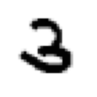

In [21]:
# sanity check -- single image tensor
s = three_tensors[5]
print(s.shape)
show_image(s);

#### Stack individual tensors (from the list) into a single tensor
- tensors are now "rank-3 tensor" because they each have 3 dimensions
- first axis is the number of images
- second axis is the height of each image
- third axis is the width of each image

In [22]:
# tensors are now "rank-3 tensor" because they each hav 3 dimensions:
# In this case, we can see that we have 6,131 images, each of size 28×28 pixels.

stacked_threes = torch.stack(three_tensors)
stacked_sevens = torch.stack(seven_tensors)

print("rank (number of axes in the tensor)\t", stacked_threes.ndim)
print("shape (size of each axis in the tensor)\t", stacked_threes.shape)

rank (number of axes in the tensor)	 3
shape (size of each axis in the tensor)	 torch.Size([6131, 28, 28])


In [23]:
# transform tensors by casting int values to floats, scale pixel values to fit between 0-1
stacked_threes = stacked_threes.float()/255
stacked_sevens = stacked_sevens.float()/255

stacked_sevens.ndim, stacked_threes.ndim

(3, 3)

## Find the "ideal" 3 and "ideal" 7 by taking the average
- Compute the ideal 3: calculate the mean of all the image tensors by taking the mean along dimension 0 of our stacked, rank-3 tensor. This is the dimension that indexes over all the images.
- In other words, for every pixel position, this will compute the average of that pixel over all images.
- The result will be one value for every pixel position, or a single image.

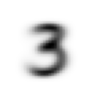

In [24]:
# get mean of every pixel (the 28x28 axes) across each image (the first axis -- 6131 images)
mean3 = stacked_threes.mean(0) # 0 means to take the average over the images (axis 0)
show_image(mean3);

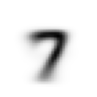

In [25]:
# get means across 7s
mean7 = stacked_sevens.mean(0)
show_image(mean7);

## Evaluate on a single sample
Measure distance from sample to ideal

rank (# axes): 2
shape of each axis: torch.Size([28, 28])


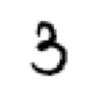

In [26]:
# pick an arbitrary 3
sample_3 = stacked_threes[732]
print("rank (# axes):", sample_3.ndim)
print("shape of each axis:", sample_3.shape)

show_image(sample_3);
# sample_3

In [27]:
# method 0: can't actually use this! demonstration only!
# add up the differences between the sample and the ideal
# (notice the positive and negative differences will cancel each other out)
dontdothis = (sample_3 - mean3)
print("differences pixel by pixel:\t\t",dontdothis.shape)
print("average difference across all pixels:\t", dontdothis.mean())

differences pixel by pixel:		 torch.Size([28, 28])
average difference across all pixels:	 tensor(-0.0203)


### L1 norm (mean absolute difference)
- Take the mean of the absolute value of differences between the sample and the ideal

In [28]:
# L1 comparing the sample and ideal 3
dist_3_abs = (sample_3 - mean3).abs().mean()
# print("differences pixel by pixel:\t\t",(a_3 - mean3).abs())
print("average difference to Ideal 3 (across all pixels):\t", dist_3_abs)

average difference to Ideal 3 (across all pixels):	 tensor(0.1095)


In [29]:
# L1 comparing the sample and ideal 7
dist_7_abs = (sample_3 - mean7).abs().mean()
print("average difference to Ideal 7(across all pixels):\t", dist_7_abs)

average difference to Ideal 7(across all pixels):	 tensor(0.1557)


In [30]:
# L1 in pytorch
import torch.nn.functional as F
F.l1_loss(sample_3.float(), mean3), F.l1_loss(sample_3.float(), mean7)

(tensor(0.1095), tensor(0.1557))

### L2 norm (root mean squared error)
- Take the mean of the square of differences between the sample and the ideal, and then take the square root of that mean
- penalizes bigger mistakes more heavily than L1 (and is more lenient with small mistakes)

In [31]:
# L2 comparing the sample and ideal 3
dist_3_sqr = ((sample_3 - mean3)**2).mean().sqrt()
print("average difference to Ideal 3 (across all pixels):\t", dist_3_sqr)

average difference to Ideal 3 (across all pixels):	 tensor(0.1968)


In [32]:
# L2 comparing the sample and ideal 7
dist_7_sqr = ((sample_3 - mean7)**2).mean().sqrt()
print("average difference to Ideal 7 (across all pixels):\t", dist_7_sqr)

average difference to Ideal 7 (across all pixels):	 tensor(0.2971)


In [33]:
# L2 in PyTorch
F.mse_loss(sample_3, mean3).sqrt(), F.mse_loss(sample_3, mean7).sqrt()

(tensor(0.1968), tensor(0.2971))

### Create distance metric
- Metrics = human-interpretable way to measure accuracy / error
- Loss = for stochastic gradient descent

In [34]:
# use L1 to measure the distance between a sample and the "ideal"
def mnist_distance(a,b):
  """
  The tuple (-1,-2) represents a range of axes.
  In Python, -1 refers to the last element, and -2 refers to the second-to-last.
  So this tells PyTorch that we want to take the mean ranging over the values
  indexed by the last two axes of the tensor -- the horizontal and vertical dimensions of an image.

  This allows the distance function to be used for a single image
  or for multiple images (which live in axis 0).
  """
  return (a-b).abs().mean((-1,-2))

In [35]:
# comparing distance from a single sample image from the ideal 3
# both sample and ideal are single-image tensors with a shape of [28,28]

sample_3_dist = mnist_distance(sample_3, mean3)
sample_7_dist = mnist_distance(sample_3, mean7)

print("L1 distance from ideal 3:", sample_3_dist)
print("L1 distance from ideal 7:", sample_7_dist)

L1 distance from ideal 3: tensor(0.1095)
L1 distance from ideal 7: tensor(0.1557)


### Create classification function
- See if the distance of the single image is closer to the ideal 3 or the ideal 7

In [36]:
def is_3(x):
  return mnist_distance(x,mean3) < mnist_distance(x,mean7)

In [37]:
# compare sample to ideal
is_3(sample_3)

tensor(True)

## Evaluate on validation set

### Get validation set

In [38]:
# validation set of 3s
valid_3_tens = torch.stack(
  [tensor(Image.open(o)) for o in (path/'valid'/'3').ls()]
)
valid_3_tens = valid_3_tens.float()/255

# validation set of 7s
valid_7_tens = torch.stack(
  [tensor(Image.open(o)) for o in (path/'valid'/'7').ls()]
)
valid_7_tens = valid_7_tens.float()/255

# each validation set is a tensor with rank 3
valid_3_tens.ndim, valid_7_tens.ndim

(3, 3)

In [39]:
# 3s validation set = 1010 images of size 28×28
# 7s validation set = 1028 images of size 28×28.
print(valid_3_tens.shape)
print(valid_7_tens.shape)

torch.Size([1010, 28, 28])
torch.Size([1028, 28, 28])


### Calculate distance metric
- Distance b/w every image and ideal 3
- Result = vector (rank 1 tensor) of distances from every image and ideal 3

In [40]:
# compare a tensor of all images (rank 3: [1010,28,28]) to the ideal tensor (rank 2: [28,28])
# for every image, we average the intensity of all the pixels in that image
valid_3_dist = mnist_distance(valid_3_tens, mean3)

# result = rank 1 tensor (vector) of length 1010 -- the number of images in the valdidation set
print("rank:", valid_3_dist.ndim)
print("shape:", valid_3_dist.shape)

# distances between the first 5 images and the ideal 3
valid_3_dist[0:5]

rank: 1
shape: torch.Size([1010])


tensor([0.1337, 0.1188, 0.1140, 0.1233, 0.1132])

### Classification Results

In [41]:
# Are the 3s in the validation set predicted to be 3s?
results_3s = is_3(valid_3_tens)

print(results_3s.shape)
accuracy_3s = results_3s.float().mean()
accuracy_3s

torch.Size([1010])


tensor(0.9168)

In [42]:
# Are the 7s in the validation set predicted to be 7s?
results_7s = is_3(valid_7_tens)

accuracy_7s = (1 - results_7s.float()).mean()
accuracy_7s

tensor(0.9854)

# Aside: Stochastic Gradient Descent
- The process of adjusting a parameter and measuring the loss (the distance to the bottom of the gradient -- here, y axis value)
- Goal is still to find the parameter value(s) (x value) where y as at its minimum value -- aka the slope = 0

In [43]:
# define quadratic function
def f(x):
  return x**2

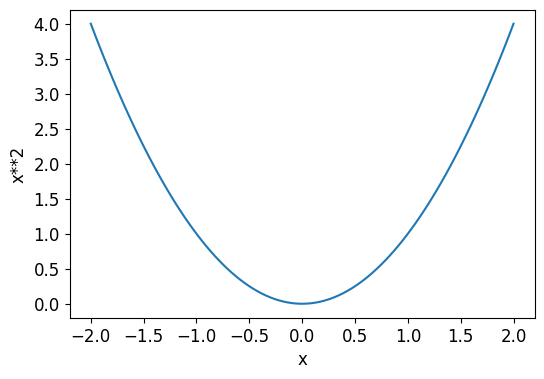

In [44]:
# plot function
plot_function(f, 'x', 'x**2')

## Manually

### Initialize a parameter
Pick a random value for the parameter (x-axis)

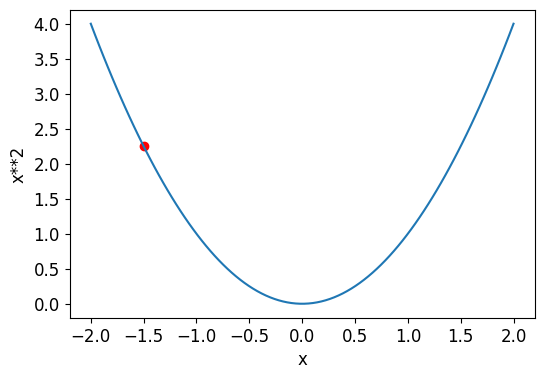

In [45]:
x = -1.5
plot_function(f, 'x', 'x**2')
plt.scatter(x, f(x), color='red');

### Measure loss
Loss = vertical distance from the parameter (the point) to the x axis

In [46]:
# loss = 2.25ish

### Step
Change the parameter to make the slope less steep.

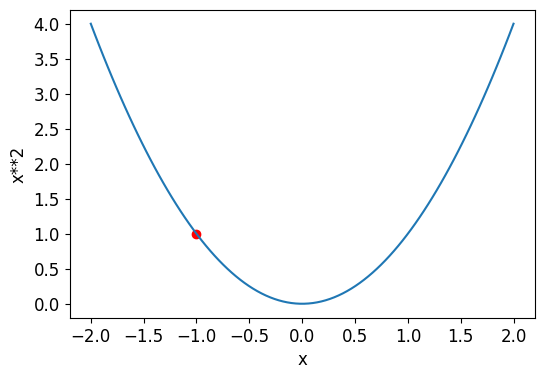

In [47]:
# move the parameter (the x value) a little to the right
x = -1.0
plot_function(f, 'x', 'x**2')
plt.scatter(x, f(x), color='red');

# loss is less now -- 1.0ish

### Iterate

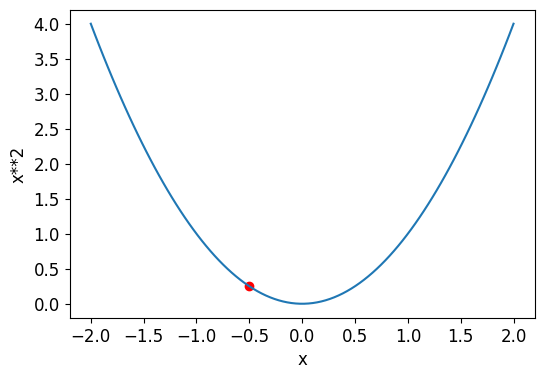

In [48]:
# step again
x = -0.5
plot_function(f, 'x', 'x**2')
plt.scatter(x, f(x), color='red');

# loss = 0.25ish

## Using calculus to find gradient (slopes)
- Data: rollercoaster speeds at different time points
- Goal: find the best (quadratic) function that fits the data -- meaning finding the parameter values that optimize the quadratic function

### Data

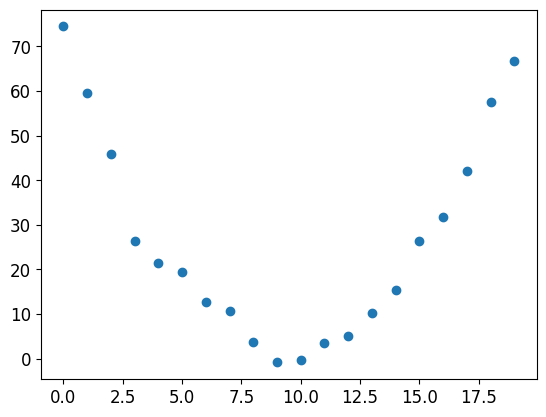

In [49]:
# make list of 20 time points (just a tensor from 0 to 20)
time = torch.arange(0,20).float()

# make possible speed times by adding noise to a quadratic function
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
plt.scatter(time,speed);

### Architecture

In [50]:
# define a (quadratic) function that will guess the speed at a particular time
def f(t, params):
  """
  t = the time we want to guess the speed at
  params = the parameters of a quadratic function --
  aka the weight for the squared term (a), linear term (b), and constant (c)
  """
  a,b,c = params
  results = (a*(t**2)) + (b*t) + c
  return results

### Initialize parameter weights
Randomly choose value(s) for parameters a, b, and c

In [51]:
# choose the parameter values (a,b,c in the quadratic function)
initial_params = torch.randn(3)

# tags the values (so PyTorch remembers to keep track of it)
params = tensor(initial_params).requires_grad_()
print(params)

tensor([-0.7658, -0.7506,  1.3525], requires_grad=True)


### Get prediction of y using the parameter (x)

In [52]:
# calculate predictions using the (quadratic) function we defined
# with the initialized parameter values
preds = f(time, params)
preds

tensor([ 1.3525e+00, -1.6391e-01, -3.2121e+00, -7.7919e+00, -1.3903e+01, -2.1547e+01, -3.0721e+01, -4.1428e+01, -5.3666e+01, -6.7436e+01, -8.2738e+01, -9.9571e+01, -1.1794e+02, -1.3783e+02,
        -1.5926e+02, -1.8222e+02, -2.0671e+02, -2.3274e+02, -2.6029e+02, -2.8938e+02], grad_fn=<AddBackward0>)

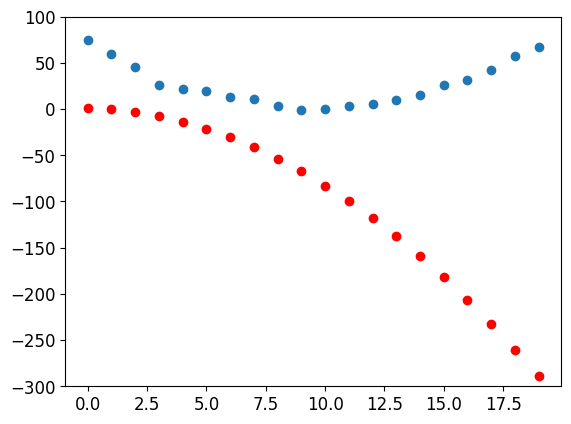

In [53]:
# show preds
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed) # actual values
    ax.scatter(time, to_np(preds), color='red') # predicted values
    ax.set_ylim(-300,100)

show_preds(preds)

### Calculate the loss
- Loss measures how good the model is
- The loss function returns a value based on a prediction and a target
- Lower loss values = better predictions

In [54]:
# loss function = mean squared error
def mse(preds, targets):
  return ((preds-targets)**2).mean()

In [55]:
# get loss for these parameter weights
loss = mse(preds, speed)
loss

tensor(25823.8086, grad_fn=<MeanBackward0>)

### Calculate the gradient (aka backpropogation)
- Gradient measures how changing each parameter weight would change the loss
- This is the derivative of the function at that parameter value (aka the slope)

In [56]:
# calculate gradient (using PyTorch's derivative function 'backward')
loss.backward()

# view the gradient (which is stored as a property of the parameter values)
# these are the slopes at the parameter values we tagged
gradient = params.grad
gradient

tensor([-53195.8633,  -3419.7148,   -253.8908])

### Step (with a learning rate)
- Step = change the parameter weight(s) based on the gradient
- Learning Rate = constant (number between 0.001 and 0.1)
- Optimizer Function = function that tells you how to adjust the parameter(s) in the direction of the slope
  - `new_param_weight -= gradient(current_param_weight) * lr`
  - increases the parameter(s) when the slope is negative
  - decreases the parameter(s) when the slope is positive
- Goal = Choose new parameter weights that minimize the loss

In [57]:
# set a learning rate (this is arbitrary for now)
lr = 1e-5

In [58]:
# update the parameters based on the gradients we just calculated using the optimizer function
params.data -= lr * gradient.data # gradient.data = where the gradient info is stored
params.grad = None # not sure what this does (keeps it from updating the params again when we don't want it to?)
params

tensor([-0.2339, -0.7164,  1.3551], requires_grad=True)

### Iterate
- Repeat the process--predict, loss, gradient, step--until you hit some criteria to stop training
- Each iteration represents an entirely different quadratic function being tried, on the way to finding the best possible quadratic function

In [59]:
def apply_step(params, prn=True):
  """
  note that this requires the lr and mse to be defined outside the function
  """
  # get preds
  preds = f(time, params)

  # get loss (mse)
  loss = mse(preds, speed)

  # get gradient
  loss.backward()
  gradient = params.grad

  # update data with optimizer function
  params.data -= lr * gradient.data
  params.grad = None

  # print loss
  if prn:
    print(f"loss, epoch {i+1} =", loss.item())

  return preds

In [60]:
# go through process 10 times -- aka 10 epochs
# the loss is going down!
for i in range(10):
  apply_step(params)

loss, epoch 1 = 5435.53564453125
loss, epoch 2 = 1577.44921875
loss, epoch 3 = 847.3778076171875
loss, epoch 4 = 709.2225341796875
loss, epoch 5 = 683.0758056640625
loss, epoch 6 = 678.1243896484375
loss, epoch 7 = 677.1838989257812
loss, epoch 8 = 677.0023803710938
loss, epoch 9 = 676.9645385742188
loss, epoch 10 = 676.9537353515625


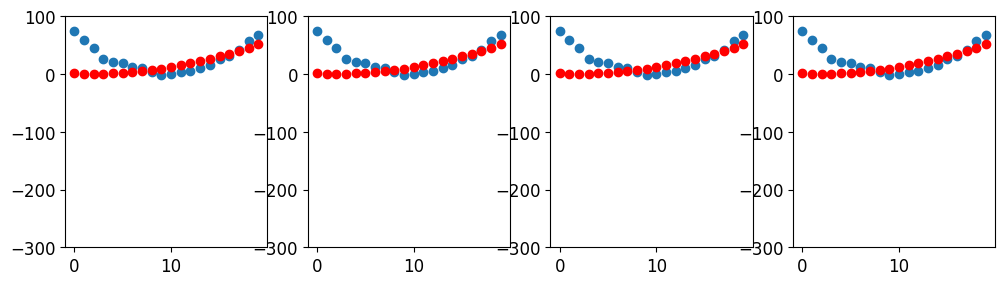

In [61]:
# # visualize this process

# # go back to original (random) params
params = initial_params.detach().requires_grad_()

# visualize preds
_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
# plt.tight_layout()

# Machine learning digit classification model
- Use a system that learns (automatically modifies itself to improve its performance) -- aka the SGD process we outlined above
- We can't improve the way the baseline model works by modifying a set of parameters -- need a new model

## Data Preprocessing

#### Images

In [62]:
# combine 3s and 7s into a single (rank 3) tensor
combine_x = torch.cat([stacked_threes, stacked_sevens])
print(combine_x.shape)

torch.Size([12396, 28, 28])


In [63]:
# convert the rank-3 tensor (list of matrices) into a rank-2 tensor (list of vectors)
# 'view' is a PyTorch method that changes shape of the tensor without changing contents
# -1 means "make the axis as big as necessary to fit all the data"
train_x = combine_x.view(-1, 28*28)
print(train_x.shape)

torch.Size([12396, 784])


#### Labels
- "3"s = 1
- "7"s = 0

In [64]:
# set labels for 3s as 1 and labels for 7s as 0
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_y.shape

torch.Size([12396, 1])

#### Create training set (images and labels)

In [65]:
# a Dataset in PyTorch is required to return a tuple of (x,y) when indexed
train_dset = list(zip(train_x,train_y))
print(len(train_dset))

12396


In [66]:
# one sample -- an image (in vector form) and its label (3 or 7)
sample_x, sample_y = train_dset[0]
print("sample x shape: image in vector form -- ", sample_x.shape)
print("sample y shape: its label (0=7, 1=3) -- ", sample_y.shape)

sample x shape: image in vector form --  torch.Size([784])
sample y shape: its label (0=7, 1=3) --  torch.Size([1])


In [67]:
# use fastai's dataloader to get randomized batches of data for training / validation
# this requires PyTorch's Dataset class
train_dl = DataLoader(train_dset, batch_size=256)
print("number of batches:", len(train_dl))

number of batches: 49


#### Create validation set

In [68]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

In [69]:
valid_dl = DataLoader(valid_dset, batch_size=256)
print("number of batches:", len(valid_dl))

number of batches: 8


#### Get first batch (for visualization processes)

In [70]:
# get first batch
xb, yb = first(train_dl)
xb.shape, yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

## Initialize parameters (weights and bias of a model)
- The weights are the w in the equation w*x+b,
- and the biases are the b in that equation.

#### Initialize Weights
One weight for every pixel

In [71]:
# create a single random weight -- with tagging for gradient later
def init_params(size, std=1.0):
  return (torch.randn(size)*std).requires_grad_()

In [72]:
# initialize weights for every pixel
weights = init_params((28*28,1))
print(weights.shape)
weights[0]

torch.Size([784, 1])


tensor([-1.0892], grad_fn=<SelectBackward0>)

#### Initilize Bias
Bias = random intercept

In [73]:
# create bias (random intercept)
bias = init_params(1)
bias

tensor([0.6863], requires_grad=True)

## Get Y Preds

In [74]:
# define the architecture we are using -- a linear model
def linear1(xb):
  """
  Plug in the first batch of x (xb) into the linear function (y = weights*x + bias)
  (@ is the sign for matrix multiplication)
  """
  y_preds = xb@weights + bias
  return y_preds

In [75]:
# get preds for one image
sample_image = xb[0]
sample_preds1 = (sample_image*weights.T).sum() + bias
sample_preds2 = linear1(sample_image)

sample_preds1, sample_preds2 # these are the same!

(tensor([3.8940], grad_fn=<AddBackward0>),
 tensor([3.8940], grad_fn=<AddBackward0>))

In [76]:
# get preds from the first batch of the training set (xb)
# this requires the weights and bias we defined outside the function
preds = linear1(xb)
preds.shape

torch.Size([256, 1])

## Get Metric
- Metric is a human-understandable measure of how well the predicted y values match with the true y values (vs loss, which is only for the computer)

In [77]:
def accuracy(preds, targets):
  """
  targets = true values (0 or 1); preds = model's predicted values
  """
  sigmoid_preds = preds.sigmoid()
  correct = (sigmoid_preds>0.5) == targets
  return correct.float().mean()

In [78]:
# get accuracy of the first batch of the training set
# preds = predicted values from plugging in the pixels (xb) into the model architecture (linear1)
accuracy(preds, yb)

tensor(0.8320)

### Get Loss

- this function will measure how distant each prediction is from 1 if the true label is a 1, and how distant it is from 0 if the true label is a 0,
- and then it will take the mean of all those distances

In [79]:
# define loss function
def mnist_loss(predictions, targets):
  # ensure predictions are between 0 and 1 (sigmoid function)
  smoothed_preds = predictions.sigmoid()

  # measure distance
  loss_value = torch.where(targets==1, 1-predictions, predictions).mean()

  return loss_value

In [80]:
# get loss for our single sample (xb[0])
sample_target = yb[0]
sample_loss = mnist_loss(sample_preds1, sample_target)
sample_loss

tensor(-2.8940, grad_fn=<MeanBackward0>)

In [81]:
# get loss for the first batch by comparing the predicted y values with the true y values for the first batch (yb)
# recall, lower loss = better
loss = mnist_loss(preds, yb)
loss

tensor(-4.8662, grad_fn=<MeanBackward0>)

### Get Gradient using Backpropogation

In [82]:
# get gradients
loss.backward()

# weights
print("shape of the weights gradient:", weights.grad.shape)
print("mean of the weights gradient:", weights.grad.mean())

# bias
print("shape of the bias gradient:", bias.grad.shape)

shape of the weights gradient: torch.Size([784, 1])
mean of the weights gradient: tensor(-0.1472)
shape of the bias gradient: torch.Size([1])


### Step

In [83]:
# use optimizer function to update bias param
lr = 1e5
bias.data -= bias.grad*lr

# reset gradients to 0 -- an annoying step needed in pytorch
bias.grad.zero_();

In [84]:
# use optimizer function to update weight params
weights.data -= weights.grad*lr
weights.grad.zero_();

### Iterate

#### Define functions to automate the process

In [85]:
# function combining the preds, loss, gradient above -- for one batch
# doesn't return anything because it confuses storing gradients on top of each other
def calc_grad(xb, yb, model):
  preds = model(xb)
  loss = mnist_loss(preds, yb)
  loss.backward()

In [86]:
# train over the entire training set (all the mini-batches in the training set)
def train_epoch(dl, model, lr, params):
  # calculate preds/loss/gradient
  for xb,yb in dl:
    calc_grad(xb,yb,model)

    # update params with the optimization function and then reset gradient
    for p in params:
      p.data -= p.grad*lr
      p.grad.zero_()

In [87]:
# get accuracy for each batch in the validation set
def validate_epoch(model):
  accs = [accuracy(model(xb), yb) for xb,yb in valid_dl]
  avg_acc = round(torch.stack(accs).mean().item(), 4)
  return avg_acc

#### One epoch

In [88]:
lr = 1.
params = weights,bias
model = linear1

train_epoch(train_dl, model, lr, params)
validate_epoch(model)

0.4932

#### 20 epochs

In [89]:
for i in range(20):
  train_epoch(train_dl, model, lr, params)
  print(validate_epoch(model), end=' ')

0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 

# Pytorch /FastAI ML model

## PyTorch

In [90]:
# pytorch linear model
linear_model = nn.Linear(28*28,1)

# this includes parameters by its design
w,b = linear_model.parameters()
w.shape, b.shape

(torch.Size([1, 784]), torch.Size([1]))

In [91]:
# create optimizer to learn from loss
class BasicOptim:
  def __init__(self,params,lr):
    self.params,self.lr = list(params),lr

  def step(self, *args, **kwargs):
    for p in self.params: p.data -= p.grad.data * self.lr

  def zero_grad(self, *args, **kwargs):
    for p in self.params: p.grad = None


opt = BasicOptim(linear_model.parameters(), lr)

In [92]:
# training single epoch
def train_epoch(model):
  for xb,yb in train_dl:
    calc_grad(xb, yb, model)
    opt.step()
    opt.zero_grad()

In [93]:
# train entire model
def train_model(model, epochs):
  for i in range(epochs):
    train_epoch(model)
    print(validate_epoch(model), end=' ')

In [94]:
# train 20 epochs
train_model(linear_model, 20)

0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 

## FastAI

In [95]:
# data loader (required input for fastai)
train_dl = DataLoader(train_dset, batch_size=256)
train_dl = DataLoader(train_dset, batch_size=256)
dls = DataLoaders(train_dl, valid_dl)

In [96]:
# same functions as above
def mnist_loss(predictions, targets):
  predictions = predictions.sigmoid()
  return torch.where(targets==1, 1-predictions, predictions).mean()

def accuracy(xb, yb):
  preds = xb.sigmoid()
  correct = (preds>0.5) == yb
  return correct.float().mean()

In [97]:
# fastai Learner
learn = Learner(
  dls, # dataloaders
  nn.Linear(28*28,1),  # same linear model as pytorch
  opt_func=SGD, # built in optimization function
  loss_func=mnist_loss, # loss function
  metrics=accuracy # metrics
)

In [98]:
# fit 10 epochs: get results from validation set
n_epochs, lr = 10, 1.
learn.fit(n_epochs, lr=lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.637416,0.503248,0.495584,00:00
1,0.457872,0.243152,0.783611,00:00
2,0.171015,0.171531,0.846909,00:00
3,0.076547,0.103520,0.913150,00:00
4,0.041575,0.076180,0.933759,00:00
5,0.027813,0.061291,0.947988,00:00
6,0.022090,0.051976,0.956330,00:00
7,0.019498,0.045771,0.963199,00:00
8,0.018155,0.041412,0.966143,00:00
9,0.017336,0.038200,0.967615,00:00


# Neural Net
Allows you to model nonlinear components to the SGD / ML process above

### Data

In [99]:
# same data as before
train_dl = DataLoader(train_dset, batch_size=256)
valid_dl = DataLoader(valid_dset, batch_size=256)
dls = DataLoaders(train_dl, valid_dl)

### Define model architecture
- a simple NN is two linear classifiers with a max function between them

In [100]:
def simple_net(xb):
  """
  w1 and w2 are weight tensors
  b1 and b2 are bias tensors
  """

  # layer 1: linear classifier
  res = xb@w1 + b1

  # layer 2: nonlinear layer (aka activation function)
  # ReLU (rectified linear unit) function -- replace every negative number with a zero
  res = res.max(tensor(0.0))

  # layer 3: linear classifier
  res = res@w2 + b2

  return res

In [101]:
# alternatively -- pytorch version
# note -- this initializes the parameters, too
pytorch_net = nn.Sequential(
  nn.Linear(28*28,30),
  nn.ReLU(),
  nn.Linear(30,1)
)

### Initialize Parameters
If not using the Pytorch version

In [102]:
# # parameters that are randomly initialized
# w1 = init_params((28*28,30))
# b1 = init_params(30)

# w2 = init_params((30,1))
# b2 = init_params(1)

### Create FastAI Learner

In [103]:
learn = Learner(
  dls,
  pytorch_net,
  opt_func=SGD,
  loss_func=mnist_loss,
  metrics=accuracy
)

### Fit the Model

In [104]:
n_epochs = 40
lr = 0.1
learn.fit(n_epochs, lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.309501,0.408556,0.505888,00:00
1,0.144519,0.229224,0.803238,00:00
2,0.080234,0.115792,0.917566,00:00
3,0.052863,0.078238,0.940137,00:00
4,0.040140,0.061121,0.955348,00:00
5,0.033635,0.051486,0.962218,00:00
6,0.029901,0.045410,0.965162,00:00
7,0.027477,0.041260,0.967615,00:00
8,0.025731,0.038246,0.968106,00:00
9,0.024376,0.035951,0.971050,00:00


### Evaluate

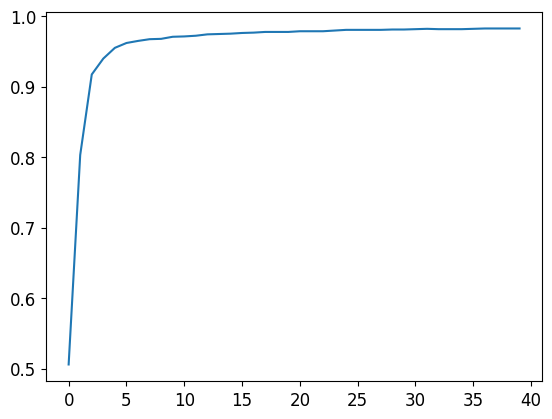

In [105]:
plt.plot(L(learn.recorder.values).itemgot(2));

In [106]:
# accuracy
learn.recorder.values[-1][2]

0.982826292514801